In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader
from torchvision import datasets, models,transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([    
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(root='cifar10', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='cifar10', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data,batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 49030880.82it/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


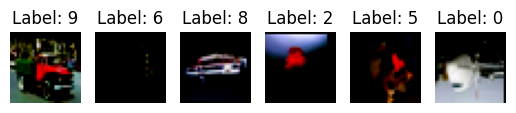

In [3]:
def show_images(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(nrows=1, ncols=6)
    for idx in range(6):
        ax = axes[idx]
        img = images[idx].permute(1, 2, 0)
        ax.imshow(img)
        ax.set_title(f"Label: {labels[idx].item()}")
        ax.axis('off')
    plt.show()

show_images(train_loader)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.3) 
        self.batch_norm1 = nn.BatchNorm2d(6) 
        self.batch_norm2 = nn.BatchNorm2d(16)
        
    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))  
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))  
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x))) 
        x = self.dropout(F.relu(self.fc2(x)))  
        x = self.fc3(x)
        return x
    
net = Net()

In [4]:
import torchvision.models as models

model = models.resnet18(pretrained=True)
for param in model.layer4.parameters():
    param.requires_grad = True

num_ftrs = model.fc.in_features  
model.fc = torch.nn.Linear(num_ftrs, 10)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),  lr=0.001, momentum= 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
def Train(model, train_loader, criterion, optimizer, scheduler, epochs):
    for epoch in range(epochs):
        running_loss = 0
        model.train()  
        
        for images, labels in train_loader:

            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch: {epoch+1}/{epochs}, Loss: {epoch_loss}")
        
        scheduler.step(epoch_loss)


In [7]:
Train(model, train_loader, criterion, optimizer,scheduler, 50)

Epoch: 1/50, Loss: 1.3248433382309917
Epoch: 2/50, Loss: 1.0017577521026593
Epoch: 3/50, Loss: 0.886973420029406
Epoch: 4/50, Loss: 0.8247406538718801
Epoch: 5/50, Loss: 0.7745168754816665
Epoch: 6/50, Loss: 0.7396895413279838
Epoch: 7/50, Loss: 0.6982139048292814
Epoch: 8/50, Loss: 0.6728741594821291
Epoch: 9/50, Loss: 0.6504850488565767
Epoch: 10/50, Loss: 0.6318324309252107
Epoch: 11/50, Loss: 0.6097684133693081
Epoch: 12/50, Loss: 0.5915881105319923
Epoch: 13/50, Loss: 0.5754598937642849
Epoch: 14/50, Loss: 0.5581322387813608
Epoch: 15/50, Loss: 0.54459233010364
Epoch: 16/50, Loss: 0.5378710903093943
Epoch: 17/50, Loss: 0.5225177055886944
Epoch: 18/50, Loss: 0.5049652814141015
Epoch: 19/50, Loss: 0.4943215800901813
Epoch: 20/50, Loss: 0.4923366623194626
Epoch: 21/50, Loss: 0.4821122862646342
Epoch: 22/50, Loss: 0.46556464384507645
Epoch: 23/50, Loss: 0.45724752472947017
Epoch: 24/50, Loss: 0.4455726973502837
Epoch: 25/50, Loss: 0.4436267167710892
Epoch: 26/50, Loss: 0.4277189553088

In [8]:
def test(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100* correct / total}%")


test(model, test_loader)

Accuracy: 80.2%


In [9]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

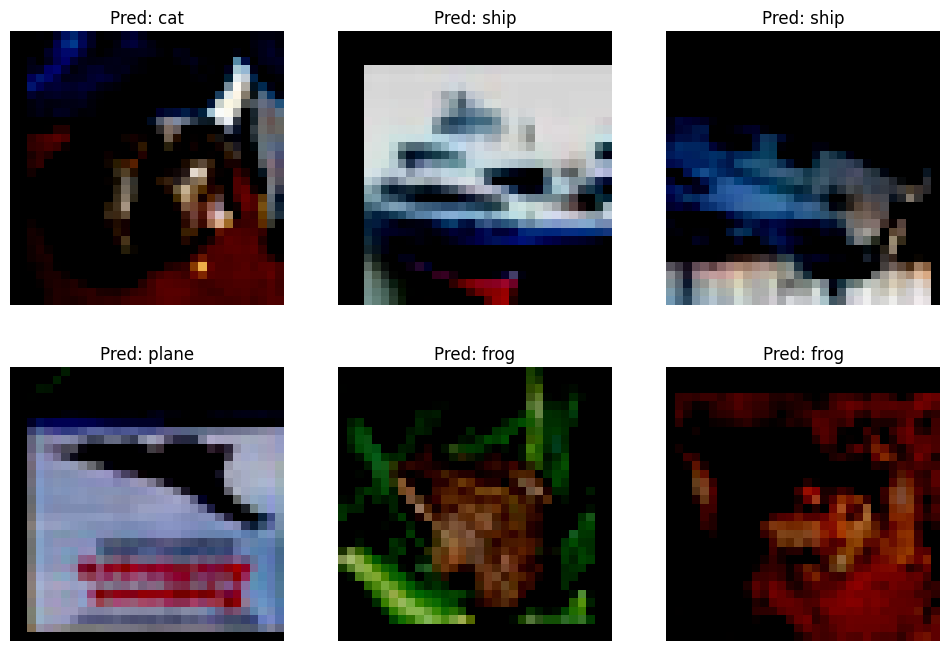

In [11]:
def show_predictions(model, test_loader):
    model.eval()  
    images, labels = next(iter(test_loader)) 
    outputs = model(images)  
    _, preds = torch.max(outputs, 1) 

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    for idx in range(6):
        ax = axes[idx]
        ax.imshow(images[idx].permute(1, 2, 0).numpy())
        ax.set_title(f"Pred: {classes[preds[idx].item()]}")
        ax.axis('off')
    plt.show()

show_predictions(model, test_loader)